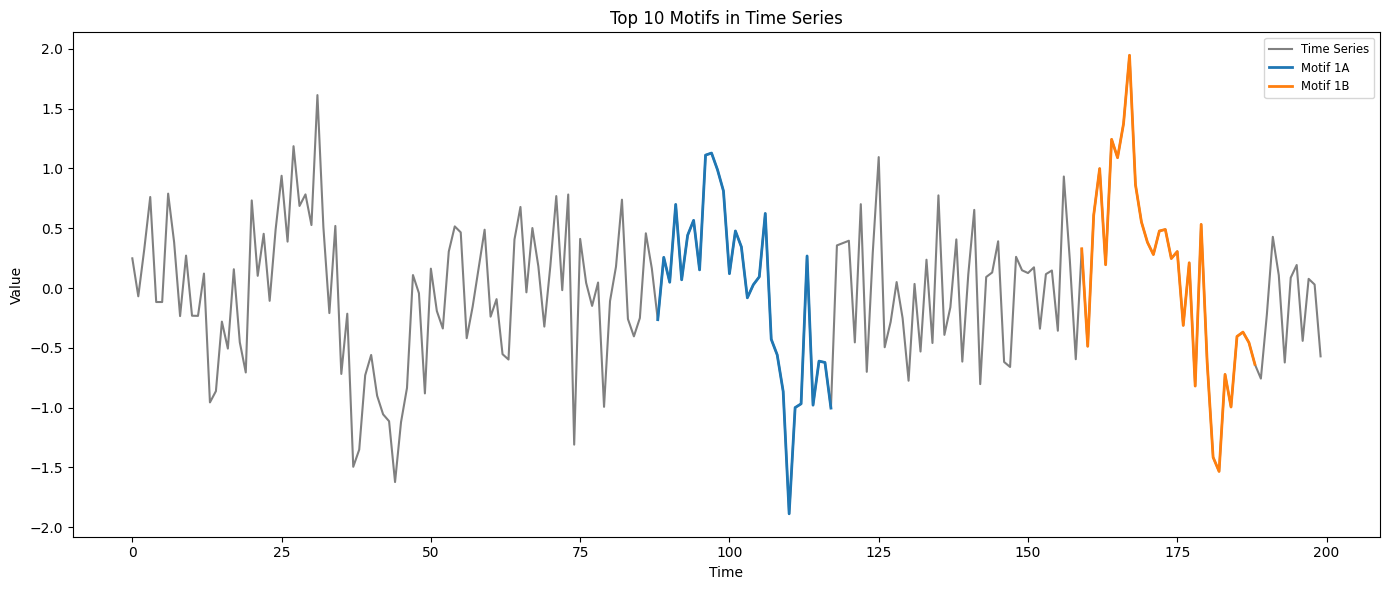

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import stumpy

# 1. Generate synthetic time series with repeating patterns (motifs)
np.random.seed(42)
t = np.arange(0, 200)
motif = np.sin(np.linspace(0, 2 * np.pi, 30))  # base motif

# Insert motif multiple times at different locations with some noise
data = np.random.normal(0, 0.5, 200)
data[20:50] += motif
data[90:120] += motif
data[160:190] += motif

# 2. Compute matrix profile
m = 30  # motif length
mp = stumpy.stump(data, m=m)

# 3. Get top 10 non-overlapping motifs


def get_top_motifs(mp, m=30, top_n=10):
    motifs = []
    used = np.zeros(len(mp), dtype=bool)
    for _ in range(top_n):
        idx = np.argmin(mp[:, 0] + used * 1e10)
        pair_idx = int(mp[idx, 1])
        if not used[idx] and not used[pair_idx]:
            motifs.append((idx, pair_idx))
            used[max(0, idx - m) : idx + m] = True
            used[max(0, pair_idx - m) : pair_idx + m] = True
    return motifs


motifs = get_top_motifs(mp, m=m, top_n=10)

# 4. Visualize the time series and motifs
plt.figure(figsize=(14, 6))
plt.plot(data, label="Time Series", color="gray")

for i, (a, b) in enumerate(motifs):
    plt.plot(np.arange(a, a + m), data[a : a + m], label=f"Motif {i+1}A", linewidth=2)
    plt.plot(np.arange(b, b + m), data[b : b + m], label=f"Motif {i+1}B", linewidth=2)

plt.title("Top 10 Motifs in Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(loc="upper right", fontsize="small")
plt.tight_layout()
plt.show()

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import stumpy
from sklearn.cluster import KMeans

np.random.seed(123)

# Generate synthetic time series data (mimicking SyntheticControl)
n_series, n_points = 100, 60
t = np.linspace(0, 10, n_points)
data = []
for i in range(n_series):
    # Mix of trends, cycles, and noise
    trend = 0.1 * i * t if i < 30 else 0
    cycle = np.sin(2 * np.pi * t * (0.5 + i / 100)) if i < 60 else np.cos(2 * np.pi * t * 0.5)
    noise = np.random.normal(0, 0.2, n_points)
    series = trend + cycle + noise
    data.append(series)
data = np.array(data)  # Shape: (100, 60)

3 [ 0.17747263 -0.79783783 -0.95902467 -1.19334686 -0.8526642  -0.44809569
  0.34100191  0.67371342  1.12146533  1.18618993]
15 [ 0.05755293 -0.33990402 -0.78097001 -1.33013491 -0.68078367 -0.35212909
  0.32644559  0.51805858  0.96722621  0.91435247]
43 [-0.7835213   0.02846838  0.46542498  1.07689507  1.32709962  0.82043095
  0.28482935  0.08852638 -0.13587102 -1.11920268]


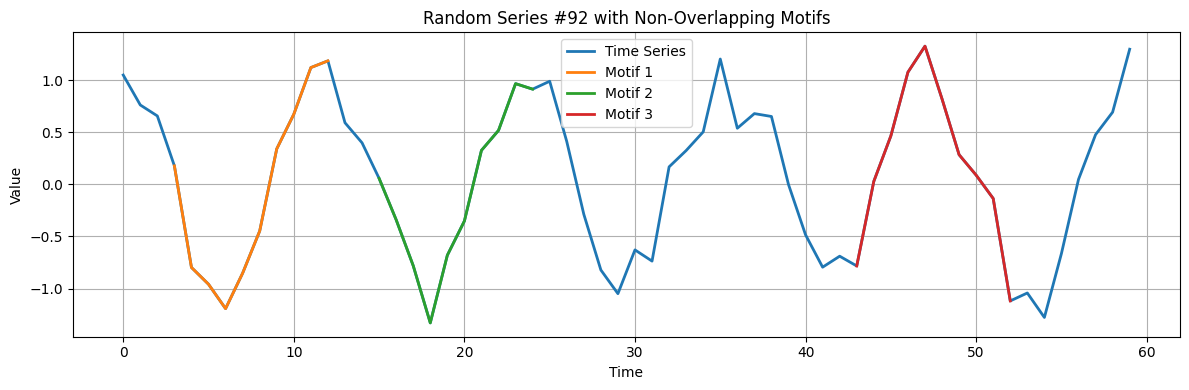

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import stumpy

# Function from before


def extract_non_overlapping_motifs(series, m=10, max_motifs=5, dist_thresh=None):
    profile = stumpy.stump(series, m=m)
    motifs = []
    profile_values = profile[:, 0].copy()

    for _ in range(max_motifs):
        min_val = np.min(profile_values)
        if dist_thresh is not None and min_val > dist_thresh:
            break
        motif_idx = np.argmin(profile_values)
        motifs.append((motif_idx, series[motif_idx : motif_idx + m]))
        # Mask overlapping regions
        mask_range = range(max(0, motif_idx - m + 1), min(len(profile_values), motif_idx + m))
        profile_values[list(mask_range)] = np.inf
    return motifs


# Choose a random series
# np.random.seed(42)
random_idx = np.random.randint(0, len(data))
series = data[random_idx]
motif_length = 10

# Extract motifs
motifs = extract_non_overlapping_motifs(series, m=motif_length, max_motifs=3)

# Plot full series with motifs highlighted
plt.figure(figsize=(12, 4))
plt.plot(series, label="Time Series", linewidth=2)

for idx, (motif_idx, motif_values) in enumerate(motifs):
    print(motif_idx, motif_values)
    plt.plot(
        range(motif_idx, motif_idx + motif_length),
        motif_values,
        label=f"Motif {idx+1}",
        linewidth=2,
    )

plt.title(f"Random Series #{random_idx} with Non-Overlapping Motifs")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

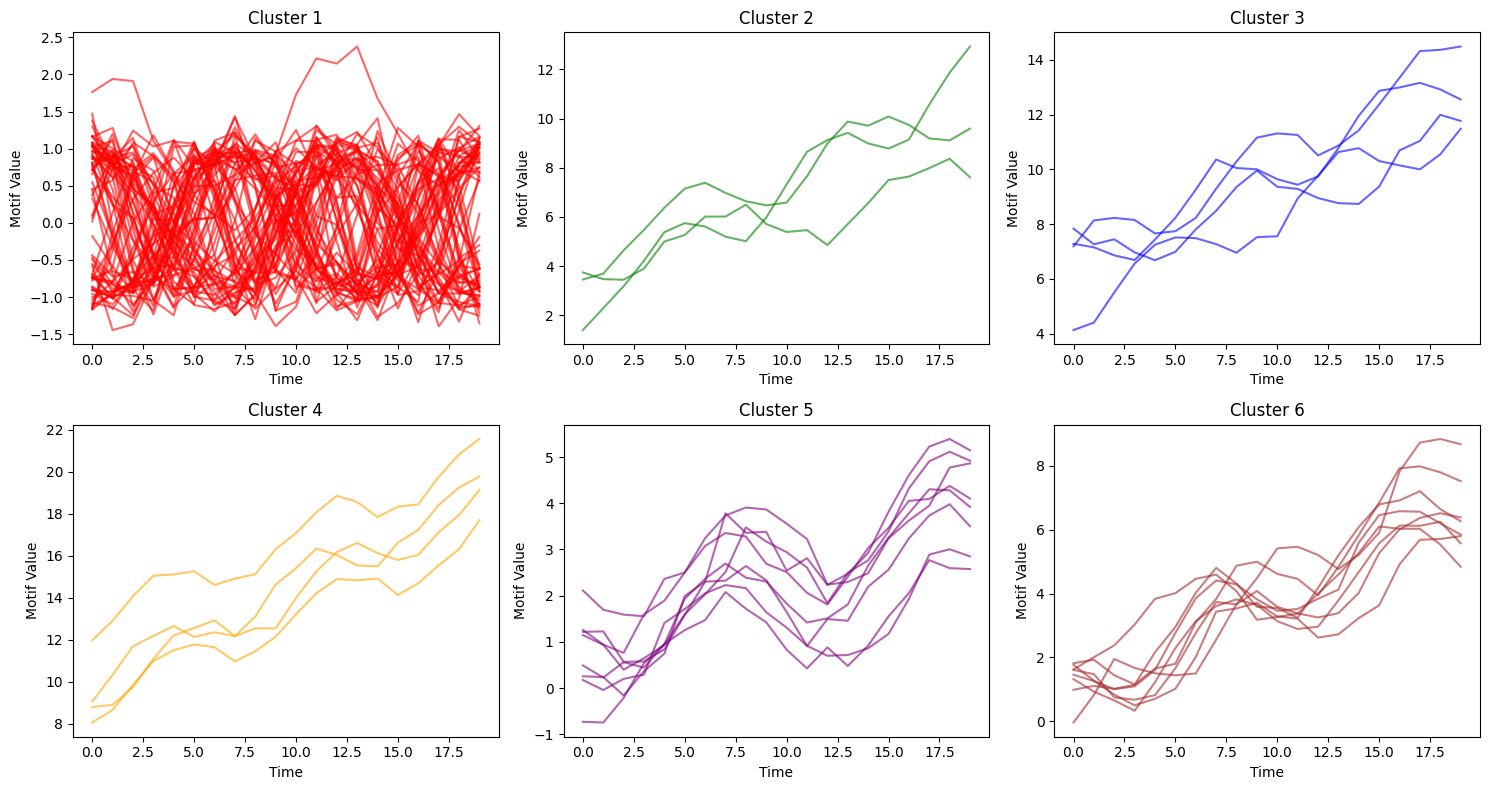

In [8]:
# Step 2: Extract top motif from each series using matrix profile
m = 20  # motif length (define it explicitly!)
motifs = []
for series in data:
    mp = stumpy.stump(series, m=m)
    motif_idx = np.argmin(mp[:, 0])
    motifs.append(series[motif_idx : motif_idx + m])
motifs = np.array(motifs)  # Shape: (100, 20)

# Step 3: Cluster motifs with KMeans
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(motifs)

# Step 4: Visualize clustered motifs
plt.figure(figsize=(15, 8))
colors = ["red", "green", "blue", "orange", "purple", "brown"]

for cluster_id in range(k):
    plt.subplot(2, 3, cluster_id + 1)
    for i in range(n_series):
        if clusters[i] == cluster_id:
            plt.plot(motifs[i], alpha=0.6, color=colors[cluster_id])
    plt.title(f"Cluster {cluster_id + 1}")
    plt.xlabel("Time")
    plt.ylabel("Motif Value")

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from tslearn.metrics import cdist_dtw

# Assume `motifs` is a 2D array with shape (n_series, motif_len)
n_series, motif_len = motifs.shape

# Normalize each motif
scaler = StandardScaler()
motifs_scaled = scaler.fit_transform(motifs)

# Precompute the distance matrix using DTW
dist_matrix = cdist_dtw(motifs_scaled)

# Perform DBSCAN clustering
eps = 0.5  # Set a distance threshold for neighborhood
min_samples = 5  # Minimum number of samples for a point to be considered a core point
db = DBSCAN(metric="precomputed", eps=eps, min_samples=min_samples)
db_labels = db.fit_predict(dist_matrix)

# Visualize DBSCAN clustering result
plt.figure(figsize=(14, 8))
unique_labels = np.unique(db_labels)
for cluster_id in unique_labels:
    plt.subplot(2, len(unique_labels) // 2, list(unique_labels).index(cluster_id) + 1)
    for i in range(n_series):
        if db_labels[i] == cluster_id:
            plt.plot(np.arange(motif_len), motifs_scaled[i], alpha=0.4)
    plt.title(f"Cluster {cluster_id if cluster_id != -1 else 'Noise'}")
    plt.xlabel("Time")
    plt.ylabel("Motif Value")
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import cdist_dtw

# Assume `motifs` is of shape (n_series, motif_len)
n_clusters = 6
n_series, motif_len = motifs.shape

# Normalize each motif
scaler = StandardScaler()
motifs_scaled = scaler.fit_transform(motifs)

# Cluster motifs using DTW or Euclidean
kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", random_state=123)
pam_clusters = kmeans.fit_predict(motifs_scaled)

# Precompute distance matrix (between motifs)
dist_matrix = cdist_dtw(motifs_scaled)

# Find medoids


def find_medoids(data, clusters, dist_matrix, n_clusters):
    medoids = []
    for k in range(n_clusters):
        cluster_indices = np.where(clusters == k)[0]
        if len(cluster_indices) > 0:
            cluster_dists = dist_matrix[cluster_indices][:, cluster_indices]
            medoid_idx = cluster_indices[np.argmin(cluster_dists.sum(axis=1))]
            medoids.append(medoid_idx)
    return medoids


medoids = find_medoids(motifs_scaled, pam_clusters, dist_matrix, n_clusters)

# Visualize motif clusters
plt.figure(figsize=(14, 8))
for cluster in range(n_clusters):
    plt.subplot(2, 3, cluster + 1)
    for i in range(n_series):
        if pam_clusters[i] == cluster:
            plt.plot(np.arange(motif_len), motifs_scaled[i], alpha=0.4)
    # Highlight medoid
    plt.plot(
        np.arange(motif_len),
        motifs_scaled[medoids[cluster]],
        color="black",
        linewidth=2.5,
        label="Medoid",
    )
    plt.title(f"Motif Cluster {cluster + 1}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
plt.tight_layout()
plt.show()

In [5]:
from collections import Counter

import numpy as np
import stumpy

m = 20  # motif length
top_k = 3
motif_pool = []

for series in data:
    mp = stumpy.stump(series, m=m)
    top_indices = np.argsort(mp[:, 0])[:top_k]
    for idx in top_indices:
        motif = series[idx : idx + m]
        motif_pool.append(motif)

motif_pool = np.array(motif_pool)  # shape: (n_series * top_k, m)

IndexError: tuple index out of range

In [4]:
motif_pool

[]